# AIIR Project - AI Mario
This jupyter notebook contains the application of nueral network and reinforcement learning algorithms learnt from the tutorials to simulate Mario completing a variety of levels in a Super Mario Bros pybullet gym environment.

## Mario Environment
We use a Super Mario Bros environment (https://pypi.org/project/gym-super-mario-bros/) with a continuous state space and discrete action space. The goal of this activity is to complete Mario levels as fast as possible while also achieving a high level score. Episodes end when Mario reaches the end of the level, if Mario dies, or if a certain time as elapsed.

### Action Space
- 0: No Movement
- 1: Move Right
- 2: Move Right + Jump
- 3: Move Right + Speed Up
- 4: Move Right + Jump + Speed Up
- 5: Jump
- 6: Move Left
- 7: Move Left + Jump
- 8: Move Left + Speed Up
- 9: Move Left + Jump + Speed Up
- 10: Down
- 11: Up

### Observation Space
The info dictionary returned by step contains the following:
| Key | Unit | Description |
| --- | ---- | ----------- |
| coins | int | Number of collected coins |
| flag_get | bool | True if Mario reached a flag |
| life | int | Number of lives left |
| score | int | Cumulative in-game score |
| stage | int | Current stage |
| status | str | Mario's status/power |
| time | int | Time left on the clock |
| world | int | Current world |
| x_pos | int | Mario's x position in the stage |
| y_pos | int | Mario's y position in the stage |

### Rewards
| Feature | Description | Value when Positive | Value when Negative | Value when Equal |
|---------|-------------|---------------------|---------------------|------------------|
| Difference in agent x values between states | Controls agent's movement | Moving right | Moving left | Not moving |
| Time difference in the game clock between frames | Prevents agent from staying still | - | Clock ticks | Clock doesn't tick |
| Death Penalty | Discourages agent from death | - | Agent dead | Agent alive |
| Coins | Encourages agent to get coins | Coin collected | - | No coin collected |
| Score | Encourages agent to get higher score | Score Value | Score Value | Score Value |
| Flag | Encourages agent to reach middle & end flag | Flag collected | - | Flag not collected |

## Importing Guide

In [1]:
# Importing required python packages
import pybullet as p
import torch
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import numpy as np
from pyvirtualdisplay import Display
from IPython.display import HTML
import os
import pickle
import random

# Importing required Super Mario Bros packages
import gym_super_mario_bros
from gym_super_mario_bros.actions import COMPLEX_MOVEMENT
from nes_py.wrappers import JoypadSpace

# Importing required directory packages for the models
from ReinforcementLearning import ReinforcementLearning
from Wrappers import apply_wrappers

# os.environ['PYVIRTUALDISPLAY_DISPLAYFD'] = '0' 
# display = Display(visible=0, size=(400, 300))
# display.start()

# Function to display the testing video of the agent in the juypyter notebook
def display_video(frames, framerate=30):
  """Generates video from `frames`.

  Args:
    frames (ndarray): Array of shape (n_frames, height, width, 3).
    framerate (int): Frame rate in units of Hz.

  Returns:
    Display object.
  """
  height, width, _ = frames[0].shape
  dpi = 70
  orig_backend = matplotlib.get_backend()
  matplotlib.use('Agg')  # Switch to headless 'Agg' to inhibit figure rendering.
  fig, ax = plt.subplots(1, 1, figsize=(width / dpi, height / dpi), dpi=dpi)
  matplotlib.use(orig_backend)  # Switch back to the original backend.
  ax.set_axis_off()
  ax.set_aspect('equal')
  ax.set_position([0, 0, 1, 1])
  im = ax.imshow(frames[0])
  def update(frame):
    im.set_data(frame)
    return [im]
  interval = 1000/framerate
  anim = animation.FuncAnimation(fig=fig, func=update, frames=frames,
                                  interval=interval, blit=True, repeat=False)
  return HTML(anim.to_html5_video())

pybullet build time: Nov 28 2023 23:45:17


## Hyperparmaters

In [2]:
DISPLAY = True                  # Sets the environment render mode to human or rgb_array
CUSTOM_REWARDS = True           # Sets state to include custom rewards
CONTUNUE_TRAINING = False       # Sets the training mode to continue from previous training
EPISODES = 20000                # Number of episodes to train the AI on
MEM_SIZE = 50000                # Size of the memory in replay buffer
REPLAY_START_SIZE = 1000        # Amount of samples to fill the replay buffer before training
NETWORK_UPDATE_ITER = 2000      # Number of iterations before learning func updates the Q weights

MEM_RETAIN = 0.1                # Size of memory that cannot be overwritten (avoids catastrophic forgetting)
BATCH_SIZE = 32                 # Size of random batches when sampling experiences
LEARNING_RATE = 0.0025          # Learning rate for optimizing neural network weights
GAMMA = 0.9                     # Discount factor for future rewards
EPSILON_START = 1.0             # Starting exploration rate
EPSILON_END = 0.1               # Ending exploration rate
EPSILON_DECAY = (0.7 * EPISODES * 250)  # Rate at which exploration rate decays

DQN_DIM1 = 512                  # Number of neurons in DQN's first hidden layer
DQN_DIM2 = 512                  # Number of neurons in DQN's second hidden layer

# Creating variables to store evaluation metrics
episode_history = []
episode_reward_history = []
episode_loss_history = []
episode_length_history = []
episode_success_history = []
episode_coin_history = []
episode_score_history = []
episode_td_error_history = []

average_episode_reward_history = []
average_episode_loss_history = []
average_episode_length_history = []
average_episode_success_history = []
average_episode_coin_history = []
average_episode_score_history = []
average_episode_td_error_history = []

episode_batch_loss = 0
episode_batch_score = 0
episode_reward = 0
episode_length = 0
episode_loss = 0
successful_episodes = 0
loss = 0
episode_td_error = 0

## Custom Rewards

In [3]:
# Defining a function to shape the environment rewards with our custom rewards
def shapeRewards(info, prev_info, done):
    # Creating constants for reward shaping
    COIN_REWARD = 1
    SCORE_REWARD = 1
    FLAG_REWARD = 500
    RIGHT_REWARD = 1
    LEFT_REWARD = -1.5
    DEATH_REWARD = -500
    TIME_REWARD = -10

    # Checking if death reward should be added
    death_reward = 0
    if done and info['flag_get'] == False:
        death_reward = DEATH_REWARD

    # Applying the movement reward
    x_pos_dif = info['x_pos'] - prev_info['x_pos']
    right_reward = 0  # Setting default reward
    if x_pos_dif > 0:
        right_reward = RIGHT_REWARD * x_pos_dif
    elif x_pos_dif < 0:
        right_reward = LEFT_REWARD * abs(x_pos_dif)
    else:
        right_reward = LEFT_REWARD

    # Checking if any custom rewards should be added
    coin_reward = COIN_REWARD * (info['coins'] - prev_info['coins'])
    score_reward = SCORE_REWARD * (info['score'] - prev_info['score'])
    flag_reward = FLAG_REWARD if info['flag_get'] else 0
    time_reward = TIME_REWARD * (prev_info['time'] - info['time'])

    # Calculating the custom reward
    custom_reward = coin_reward + score_reward + flag_reward + right_reward + death_reward + time_reward
    return custom_reward  # Returning the custom reward

## Training the AI

In [ ]:
# Setting path for saving the model policy network
save_path = os.path.join(os.getcwd(), "policy_network.pkl")

# Ensuring a CUDA GPU device is available
if torch.cuda.is_available():
    # Creating device variable and setting it to the CUDA device
    device = torch.device("cuda")
    print("Using CUDA device: ", torch.cuda.get_device_name(0))  # Printing CUDA device name
else:
    print("CUDA GPU is not available")

# Creating the Super Mario Bros environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', render_mode='human' if DISPLAY else 'rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env = apply_wrappers(env)  # Applying the custom wrapper for the environment

# Creating DQN Reinforcement Learning Agent
agent = ReinforcementLearning(env, MEM_SIZE, MEM_RETAIN, BATCH_SIZE, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, NETWORK_UPDATE_ITER, REPLAY_START_SIZE, DQN_DIM1, DQN_DIM2)

# Load the saved model and history data if CONTINUE_TRAINING is set to True
if CONTUNUE_TRAINING:
    saved_model = torch.load(save_path)
    agent.policy_network.load_state_dict(saved_model)

    # Load history data
    with open('history_data1.pkl', 'rb') as f:
        (episode_history, average_episode_reward_history, average_episode_loss_history, 
            average_episode_length_history, average_episode_success_history, average_episode_coin_history, average_episode_score_history, average_episode_td_error_history) = pickle.load(f)

# Initialising and resetting the environment
env.reset()
state, reward, done, trunc, info = env.step(action=0)

# Looping through the episodes to train the model
for episode in range(EPISODES):
    done = False  # Setting default done state
    prev_info = None  # Setting previous info to None
    state, info = env.reset()  # Resetting environment and getting state

    # Running the episode until done (indicated by death or by reaching the goal)
    while not done:
        # Sampling an action to take within the environment
        action = agent.choose_action(state)
        state_, reward, done, trunc, info = env.step(action)

        # Adding custom rewards to the environment
        if CUSTOM_REWARDS and prev_info is not None:
            custom_reward = shapeRewards(info, prev_info, done)
            reward = custom_reward  # Adding custom reward to environment default reward

        # Adding the experience to the memory and checking if we should train the model
        agent.memory.add(state, action, reward, state_, done)  # Adding experience to replay buffer
        if agent.memory.memory_count >= REPLAY_START_SIZE:
            loss, td_error = agent.learn()  # Updating Q-value weights of the neural network
            episode_batch_loss += loss  # Updating batch loss
            episode_loss += loss  # Updating episode loss
            episode_td_error += td_error  # Updating episode td_error

        state = state_  # Updating current state
        prev_info = info  # Updating previous info

        # Updating performance metrics
        episode_reward += reward  # Updating episode reward
        episode_batch_score += reward  # Update episode score
        episode_length += 1 # Updating episode length

    # Appending episodes and rewards to the history for performance metrics
    print("Epsiode: ", episode, " Reward: ", episode_reward)
    if info['flag_get'] == True:
            successful_episodes += 1  # Updating successful episodes counter
    episode_reward_history.append(episode_reward)
    episode_loss_history.append(episode_loss)
    episode_length_history.append(episode_length)
    episode_coin_history.append(info['coins'])
    episode_score_history.append(info['score'])
    episode_td_error_history.append(episode_td_error)

    episode_reward = 0  # Resetting episode reward
    episode_length = 0  # Resetting episode length
    episode_loss = 0  # Resetting episode loss
    episode_td_error = 0  # Resetting episode td_error

    # Saving model every batches of 100 episodes
    if episode % 100 == 0 and agent.memory.memory_count > REPLAY_START_SIZE:
        torch.save(agent.policy_network.state_dict(), save_path)
        print("Average total reward per episode batch since episode ", episode, ": ", episode_batch_score/ float(100))
        print("Average total loss per episode batch since episode ", episode, ": ", episode_batch_loss/ float(100))
        episode_batch_score = 0  # Resetting batch score for next batch
        episode_batch_loss = 0  # Resetting batch loss for next batch

    # Updating the histories every 500 episodes
    if episode % 500 == 0:
        episode_history.append(episode)
        average_episode_reward_history.append(sum(episode_reward_history[-500:]) / 500)
        average_episode_loss_history.append(sum(episode_loss_history[-500:]) / 500)
        average_episode_length_history.append(sum(episode_length_history[-500:]) / 500)
        average_episode_coin_history.append(sum(episode_coin_history[-500:]) / 500)
        average_episode_score_history.append(sum(episode_score_history[-500:]) / 500)
        average_episode_td_error_history.append(sum(episode_td_error_history[-500:]) / 500)
        average_episode_success_history.append(successful_episodes)
        successful_episodes = 0

env.close()

In [8]:
# Save history data
with open('history_data1.pkl', 'wb') as f:
    pickle.dump((episode_history, average_episode_reward_history, average_episode_loss_history, 
        average_episode_length_history, average_episode_success_history, average_episode_coin_history, average_episode_score_history, average_episode_td_error_history), f)

## Performance Metrics

In [ ]:
# Load history data
with open('history_data1.pkl', 'rb') as f:
    (episode_history, average_episode_reward_history, average_episode_loss_history, 
        average_episode_length_history, average_episode_success_history, average_episode_coin_history, average_episode_score_history, average_episode_td_error_history) = pickle.load(f)

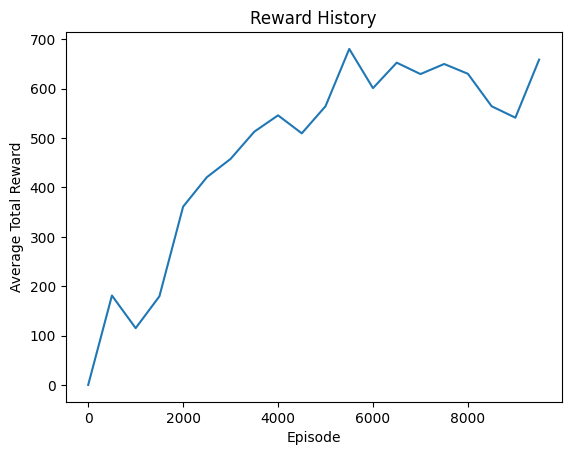

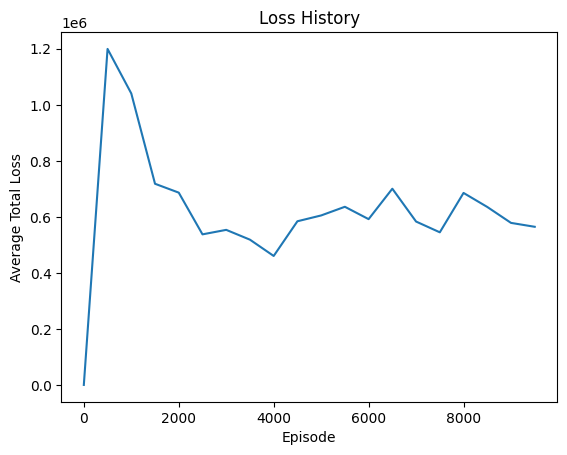

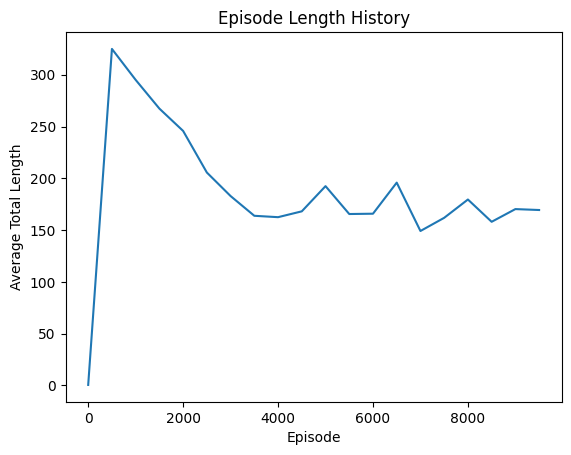

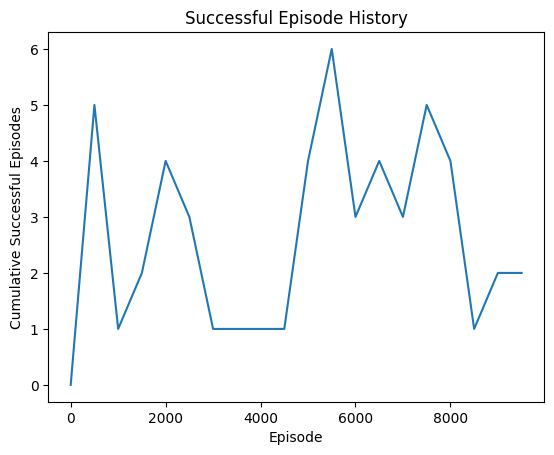

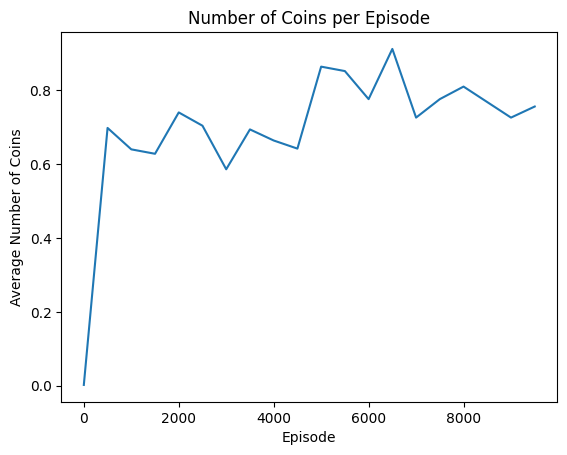

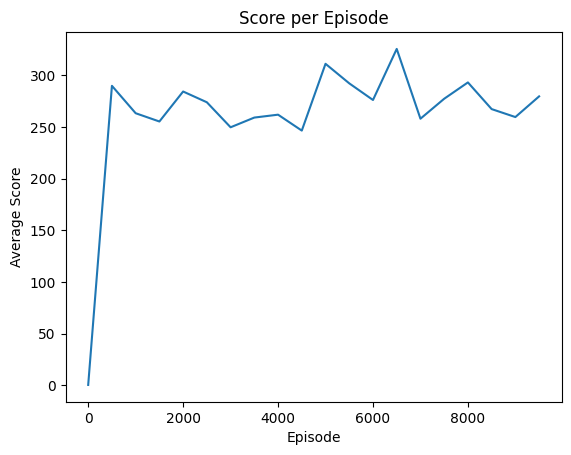

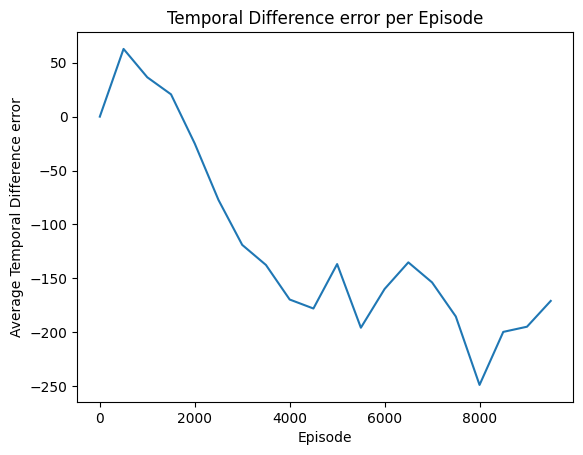

In [5]:
# Plotting episode reward history
plt.figure()
plt.plot(episode_history, average_episode_reward_history)
plt.title('Reward History')
plt.xlabel('Episode')
plt.ylabel('Average Total Reward')
plt.show()

# Plotting episode loss history
plt.figure()
plt.plot(episode_history, average_episode_loss_history)
plt.title('Loss History')
plt.xlabel('Episode')
plt.ylabel('Average Total Loss')
plt.show()

# Plotting episode length history
plt.figure()
plt.plot(episode_history, average_episode_length_history)
plt.title('Episode Length History')
plt.xlabel('Episode')
plt.ylabel('Average Total Length')
plt.show()

# Plotting episode success history
plt.figure()
plt.plot(episode_history, average_episode_success_history)
plt.title('Successful Episode History')
plt.xlabel('Episode')
plt.ylabel('Cumulative Successful Episodes')
plt.show()

# Plotting episode coins history
plt.figure()
plt.plot(episode_history, average_episode_coin_history)
plt.title('Number of Coins per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Number of Coins')
plt.show()

# Plotting episode score history
plt.figure()
plt.plot(episode_history, average_episode_score_history)
plt.title('Score per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Score')
plt.show()

# Plotting episode td_error history
plt.figure()
plt.plot(episode_history, average_episode_td_error_history)
plt.title('Temporal Difference error per Episode')
plt.xlabel('Episode')
plt.ylabel('Average Temporal Difference error')
plt.show()

## Testing the AI

In [ ]:
# Creating the Super Mario Bros environment
env = gym_super_mario_bros.make('SuperMarioBros-1-1-v0', render_mode='human' if DISPLAY else 'rgb_array', apply_api_compatibility=True)
env = JoypadSpace(env, COMPLEX_MOVEMENT)
env = apply_wrappers(env)  # Applying the custom wrapper for the environment

# Creating DQN Reinforcement Learning Agent
agent = ReinforcementLearning(env, MEM_SIZE, MEM_RETAIN, BATCH_SIZE, LEARNING_RATE, GAMMA, EPSILON_START, EPSILON_END, EPSILON_DECAY, NETWORK_UPDATE_ITER, REPLAY_START_SIZE, DQN_DIM1, DQN_DIM2)

# Initialising and resetting the environment
state, info = env.reset()
state, reward, done, trunc, info = env.step(action=0)

# Loading the saved model policy network
agent.policy_network.load_state_dict(torch.load("policy_network.pkl"))  # Loading policy network

frames = []  # Frames container for video
frames.append(env.render())  # Appending initial frame to video
agent.policy_network.eval()  # Setting policy network to evaluation mode

# Running the episode until done (indicated by death or by reaching the goal)
while True:
    # Getting the Q-values from the trained neural network
    with torch.no_grad():
        state_tensor = torch.tensor(state, dtype=torch.float32).unsqueeze(0).to(agent.memory.device)
        q_values = agent.policy_network(state_tensor)

    # Taking steps in the environment based on the Q-values for the given state
    action = torch.argmax(q_values).item()
    state, reward, done, trunc, info = env.step(action)
    frames.append(np.copy(env.render()))  # Appending frame to video

    # Breaking the loop if the episode is done
    if done:
        break

env.close()  # Closing the environment
display_video(frames)